In [145]:

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import statsmodels.api as sm
from ISLP.models import (ModelSpec as MS,
                         summarize)
from ISLP import confusion_table
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("../data/card_transdata.csv")
print(df.head())

   distance_from_home  distance_from_last_transaction  \
0           57.877857                        0.311140   
1           10.829943                        0.175592   
2            5.091079                        0.805153   
3            2.247564                        5.600044   
4           44.190936                        0.566486   

   ratio_to_median_purchase_price  repeat_retailer  used_chip  \
0                        1.945940              1.0        1.0   
1                        1.294219              1.0        0.0   
2                        0.427715              1.0        0.0   
3                        0.362663              1.0        1.0   
4                        2.222767              1.0        1.0   

   used_pin_number  online_order  fraud  
0              0.0           0.0    0.0  
1              0.0           0.0    0.0  
2              0.0           1.0    0.0  
3              0.0           1.0    0.0  
4              0.0           1.0    0.0  


In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [147]:
df.shape

(1000000, 8)

In [148]:
df.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


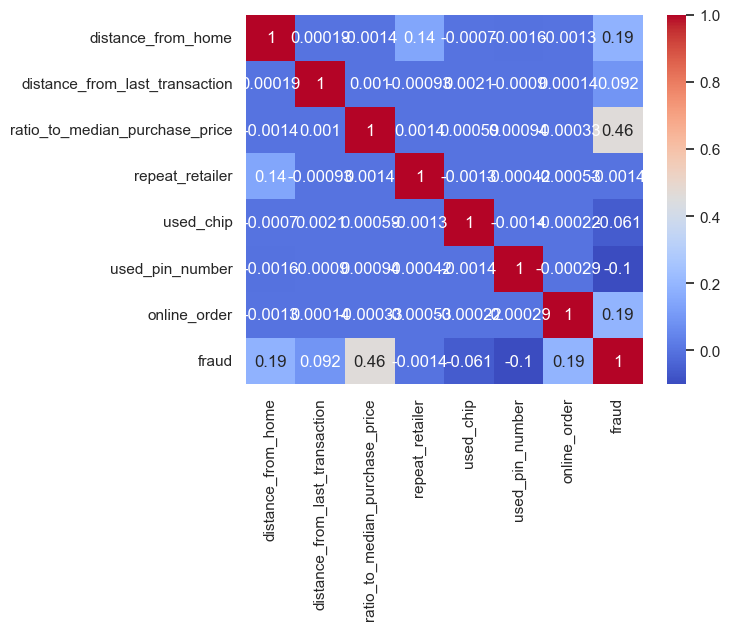

In [149]:
corr_matrix = df.corr()
# Visualize the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

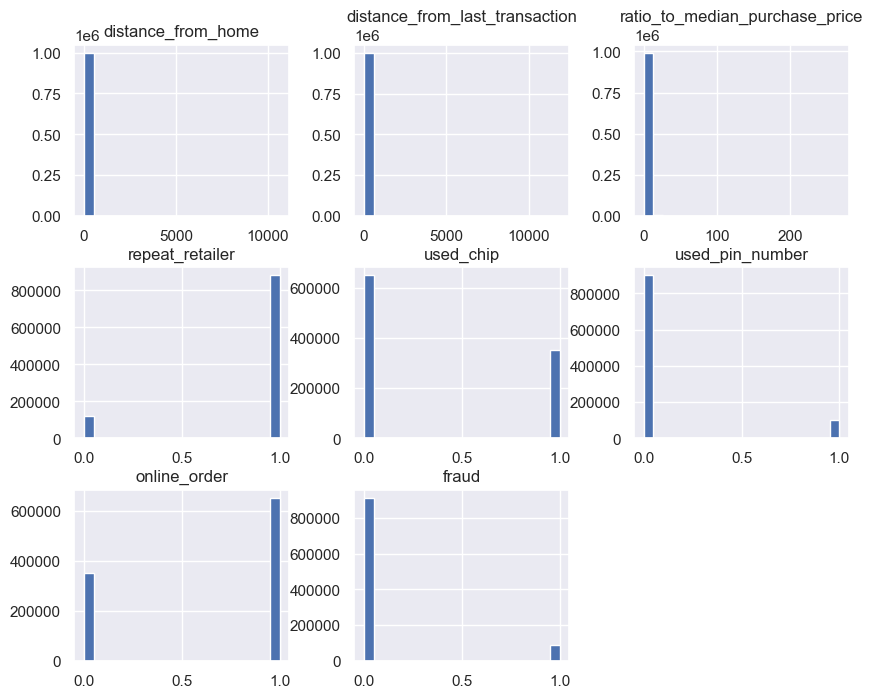

In [150]:
import matplotlib.pyplot as plt

df.hist(bins=20, figsize=(10, 8))
plt.show()

In [151]:
y = df['fraud']
X = MS(['distance_from_home','distance_from_last_transaction','ratio_to_median_purchase_price','repeat_retailer','used_chip','used_pin_number','online_order']).fit_transform(df) 
#X = df.drop('fraud', axis='columns')
#X = sm.add_constant(X)
model1 = sm.OLS(y, X)
results1 = model1.fit()
summarize(results1)

,coef,std err,t,P>|t|
intercept,-0.0541,0.001000,-68.166,0.0
distance_from_home,0.0008,0.000004,229.163,0.0
distance_from_last_transaction,0.0010,0.000009,109.958,0.0
ratio_to_median_purchase_price,0.0467,0.000084,556.705,0.0
repeat_retailer,-0.0258,0.001000,-35.097,0.0
used_chip,-0.0364,0.000000,-73.917,0.0
used_pin_number,-0.0942,0.001000,-120.766,0.0
online_order,0.1139,0.000000,231.369,0.0


In [152]:
# Perform regression
model = sm.OLS.from_formula('fraud ~ distance_from_home * distance_from_last_transaction', data=df)
result = model.fit()

# Print the summary of the regression
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  fraud   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                 1.529e+04
Date:                Wed, 19 Jun 2024   Prob (F-statistic):               0.00
Time:                        20:22:54   Log-Likelihood:            -1.3217e+05
No. Observations:             1000000   AIC:                         2.644e+05
Df Residuals:                  999996   BIC:                         2.644e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

In [153]:
# Perform regression with variableinteractions
model = sm.OLS.from_formula('fraud ~ distance_from_last_transaction * ratio_to_median_purchase_price* distance_from_home* used_chip', data=df)
result = model.fit()

# Print the summary of the regression
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  fraud   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                 2.645e+04
Date:                Wed, 19 Jun 2024   Prob (F-statistic):               0.00
Time:                        20:22:56   Log-Likelihood:                 12463.
No. Observations:             1000000   AIC:                        -2.489e+04
Df Residuals:                  999984   BIC:                        -2.471e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

In [154]:
#Try the KNN model
# Select predictors (excluding the last column)
predictors = df.iloc[:, :-1]
# Standardize the predictors
scaler = StandardScaler()
predictors_standardized = pd.DataFrame(scaler.fit_transform(predictors), columns=predictors.columns)

# Display the head of the standardized predictors
print(predictors_standardized.head())
# Create a random vector of True and False values
np.random.seed(4)
split = np.random.choice([True, False], size=len(predictors_standardized), replace=True, p=[0.75, 0.25])

# Define the training set for X (predictors)
training_X = predictors_standardized[split]

# Define the training set for Y (response)
training_Y = df.loc[split, 'fraud']

# Define the testing set for X (predictors)
testing_X = predictors_standardized[~split]

# Define the testing set for Y (response)
testing_Y = df.loc[~split, 'fraud']

   distance_from_home  distance_from_last_transaction  \
0            0.477882                       -0.182849   
1           -0.241607                       -0.188094   
2           -0.329369                       -0.163733   
3           -0.372854                        0.021806   
4            0.268572                       -0.172968   

   ratio_to_median_purchase_price  repeat_retailer  used_chip  \
0                        0.043491         0.366584   1.361576   
1                       -0.189300         0.366584  -0.734443   
2                       -0.498812         0.366584  -0.734443   
3                       -0.522048         0.366584   1.361576   
4                        0.142373         0.366584   1.361576   

   used_pin_number  online_order  
0        -0.334458     -1.364425  
1        -0.334458     -1.364425  
2        -0.334458      0.732909  
3        -0.334458      0.732909  
4        -0.334458      0.732909  


In [155]:
knn = KNeighborsClassifier(n_neighbors =3)
knn_fit=knn.fit(training_X,training_Y)
knn_pred = knn.predict(testing_X)
confusion_table(knn_pred,testing_Y)

Truth,0.0,1.0
Predicted,,
0.0,228985,195
1.0,116,21915


In [156]:
prediction_accuracy = knn.score(testing_X,testing_Y)
print(prediction_accuracy)

0.998761996887079
